# Sentiment Analysis - BERT training

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import math
from collections import defaultdict
from textwrap import wrap
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder

import wandb

import nltk.data
from nltk.tokenize import sent_tokenize
from nltk.corpus import alpino

from imblearn.over_sampling import RandomOverSampler

### Configure

Libraries settings

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Model settings

In [3]:
PRE_TRAINED_MODEL_NAME = 'wietsedv/bert-base-dutch-cased'
LEN_SENTS = 100

Wandb settings to track experiment

In [4]:
#wandb.init(project="histaware")
wandb.config.dataset = "edo_1990s"

### Import data

In [24]:
gas = pd.read_csv("sentiment/edo_1990s_gas_labeled.csv")
gas = gas[gas.energy == "Y"]
gas = gas[gas.sentiment != None]

In [25]:
olie = pd.read_csv("sentiment/edo_1990s_olie_labeled.csv")
olie = olie[olie.energy == "Y"]
olie = olie[olie.sentiment != None]

In [26]:
kool = pd.read_csv("sentiment/edo_1990s_kool_labeled.csv")
kool = kool[kool.energy == "Y"]
kool = kool[kool.sentiment_coal != None]
kool.drop(["sentiment", "sentiment_gas", "sentiment_oil"], axis=1, inplace=True)
kool.rename(columns = {"sentiment_coal": "sentiment"}, inplace=True)

In [27]:
df = pd.concat([gas, olie, kool], ignore_index=True)
df.text.replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)
df.sentiment.replace('', np.nan, inplace=True)
df.dropna(subset=['sentiment'], inplace=True)
df.shape

(1066, 24)

### Labels

In [28]:
cleanup_sentiment = {"sentiment": {"VN": 1, "NG": 2, "NE": 3, "PO": 4, "VP": 5}}
df = df.replace(cleanup_sentiment)

Plot

In [29]:
#ax = sns.countplot(df.sentiment)
#plt.xlabel('review sentiment')

Reduce from 5 labels to 3 because of lack of labels

In [30]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.sentiment.apply(to_sentiment)

Plot result reduction of labels

In [31]:
#ax = sns.countplot(df.sentiment)
#plt.xlabel('review sentiment')

### Split text and explode

In [32]:
def unite(l, n):
    """Unite sentences previously split using nltk.tokenize."""
    count = []
    chunks = []
    sents = []
    for s in l:
        count.append(len(s.split()))
    value = 0
    prev_idx = 0
    for i in range(0, len(count)):
        if value == 0:
            value = value + count[i]
        elif (i+1 == len(count)):
            chunks.append(l[prev_idx:i])
            value = 0
        elif value >= n:
            chunks.append(l[prev_idx:i])
            prev_idx = i
            value = 0
        else:
             value = value + count[i]
    for c in chunks:
        sents.append(' '.join(c))
    return(sents)

In [33]:
def splitter(s, n):
    """Split sentences only using the number of words."""
    pieces = s.split()
    return [" ".join(pieces[i:i+n]) for i in range(0, len(pieces), n)]

In [39]:
df["text_split"] = df["text"].apply(sent_tokenize)
df["text_split"] = df["text_split"].apply(unite, n = LEN_SENTS)
df.text_split.replace([], np.nan, inplace=True)
df.dropna(subset=['text_split'], inplace=True)
# Cancel all text_split == 0
df.drop(df[df.text_split.map(len) == 0].index, inplace=True)
# Currently not splitting the cleaned sentences
#df["text_clean_split"] = df["text_clean"].apply(splitter, n = LEN_SENTS)

### Load Pre-trained BERT model

In [41]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Verify the max tokens length in text_split

In [48]:
MAX_LEN = 0
def max_len(x):
    lengths = []
    for i in x:
        lengths.append(len(tokenizer.encode(i.split())))
    res = max(lengths)
    return(res)
    
temp = df["text_split"].apply(max_len)
MAX_LEN = max(temp)
MAX_LEN

361

In [49]:
df = df.explode('text_split')
df.shape

(2342, 25)

In [53]:
token_lens = []
for txt in df.text_split:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

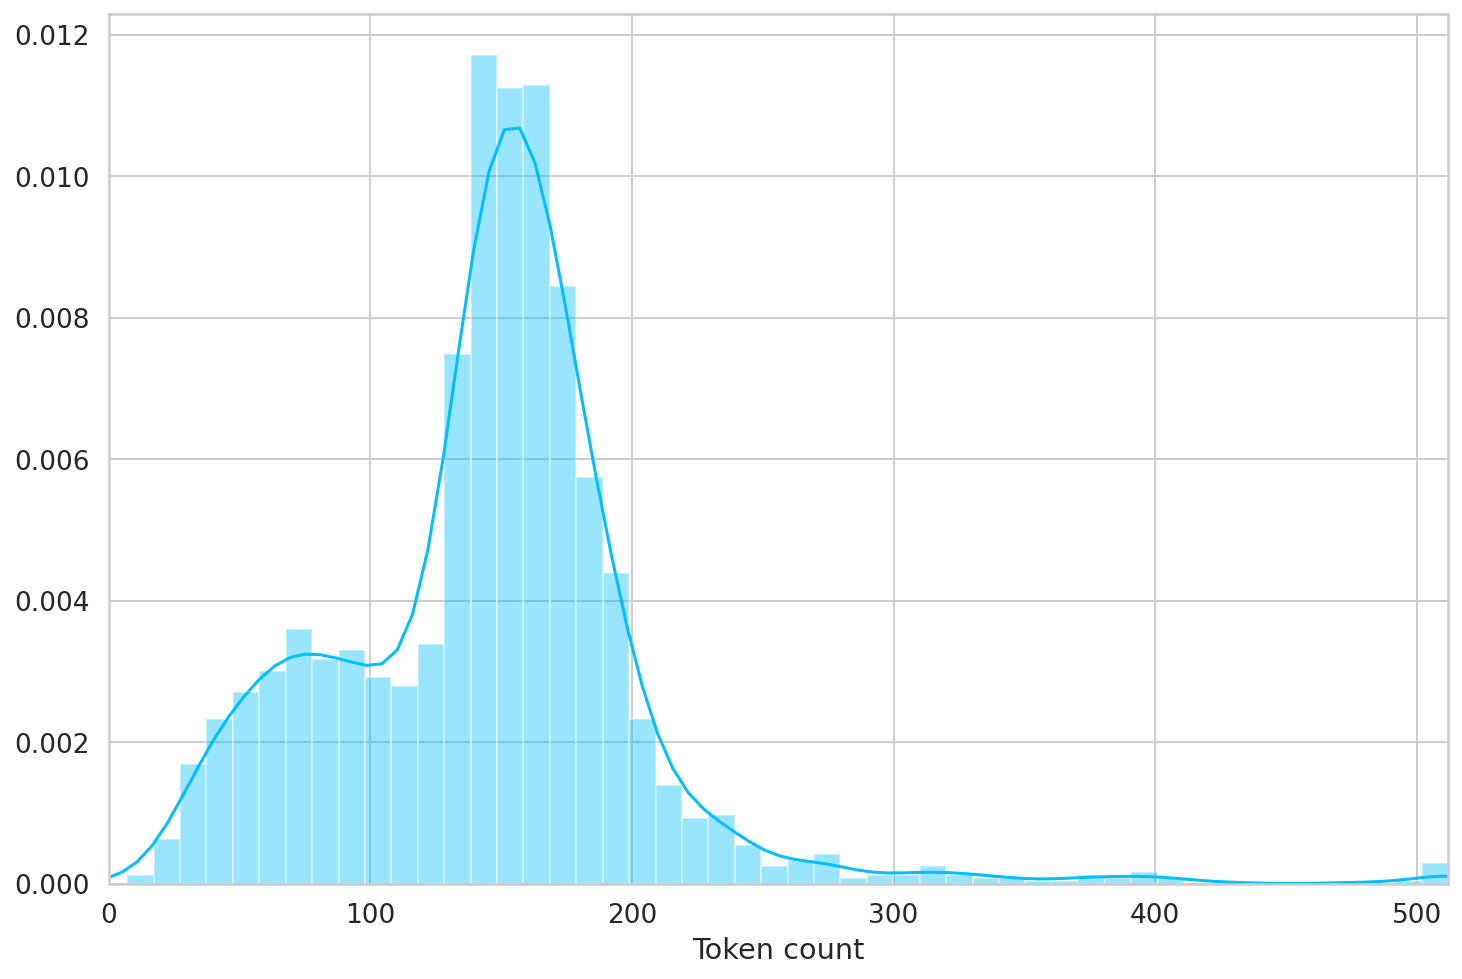

In [54]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [55]:
class HADataset(Dataset):
    # Characterizes a dataset for Pytorch
    def __init__(self, articles, labels, tokenizer, max_len):
        # Initialization
        self.articles = articles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        # Total number of articles
        return len(self.articles)

    def __getitem__(self, item):
        # Generates one sample of the data/article
        article = str(self.articles[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
          'article_text': article,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [38]:
df_train, df_test = train_test_split(
  df,
  test_size=0.25,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [61]:
def create_data_loader(df, tokenizer, batch_size, num_workers):
    ds = HADataset(
        articles=df.text_split.to_numpy(),
        labels=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
      )
    
    return DataLoader(
        ds,
        batch_size,
        num_workers
      )

### Use ImbSampling

In [62]:
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train_ros, y_train_ros = ros.fit_resample(df_train.text_split, df_train.sentiment)
X_train = pd.DataFrame(X_train_ros, columns=X_train.columns)

ValueError: Expected 2D array, got 1D array instead:
array=[': ~? koersindex op de beurs jj1 Frankfort sloot 8 punten eter, na \'s morgens nog op 19 winst te hebben ge- In Londen moest de , dcx als gevolg van winstne- 2 punten terug, na berder op de dag 15 punten , °ven het voorgaande slot te ebben gestaan. De koers van *j Amerikaanse dollar was op Mi\'B2o aan het slot ruim een yialve cent lager. A ondertoon blijft hier "Ï kftekend\'\\ zo zei een handels °Pgewekt, daarbij er op .|j ]2£nd dat de vraag zowel uit J iet binnen- als het buitenland AS**- ook het feit>dat de J V^onele beleggers weer orzichtig in de markt operev n had op de stemming van .'
 'De in Johannesburg geboren John Gibosn Kilroe is sinds januari 1989 directeur van Shell Zuid-Afrika. Tegenover de Nederlandse kamerdelegatie en de meereizende journalisten laat Kilroe er geen twijfel over bestaan waar Shell staat in Zuid-Afrika. Samen met zijn directeur interne opleidingen en communicatie, doet Kilroe uit de doeken, hoe Shell opereert in Zuid- Afrika. Die wijze van opereren mag opvallend genoemd worden. Hoewel de multinational in Zuid-Afrika zich niet in partijpolitiek wil mengen, bedrijft men toch politiek. In grote advertenties heeft Shell stelling genomen tegen apartheid en heeft het zich uitgesproken vooreen non- radicaal, democratisch Zuid- Afrika. Ook heeft het bedrijf geijverd om de mensenrechten voor iedereen te doen gelden.'
 'Shell beklemtoont dat het gaat om een zuiver commerciële beslissing en dat het concern bij haar activiteiten op zee de strengste veiligheidsnormen in acht zal blijven nemen. De maatschappij stelt vast dat de Amerikaanse milieuwetgeving een complex mengsel is van federale en staatsvoorschriften. Daar komt bij dat de VS niet behoren tot de ondertekenaars van internationale conventies die in veel andere landen de aansprakelijkheid bij olievervuiling regelen en aan maxima binden. Het gevolg is dat reders in de VS te maken kunnen krijgen met onverzekerbare claims, ook al hebben zij verantwoord gehandeld, aldus Shell. De Nederlands/Britse onderneming is de eerste grote oliemaatschappij die het tankertransport gaat beperken om eventuele milieuclaims te ontlopen.'
 ...
 'Een gigant in zee. Dat is slechts een zeer beknopte omschrijving van het enorme boorplatform Troïl, dat Shell momenteel bouwt in een fjord in Noorwegen. Maar liefst 430 meter hoog moet het gevaarte worden, dat in 1995 naar zijn plaats in open zee zal worden gesleept. Deze hoogte komt overeen met bij na anderhalf keer de Eiffeltoren, ofwel ruim vier keer de Dom van Utrecht. Het gewicht van Troll spreekt bijkans nog meer tot de verbeelding. De onder meer 200.000 m 3 beton en 100.000 m 3 staal zorgen voor een totaal gewicht van ruim 700.000 ton, ongeveer wat alle Nederlanders bij elkaar wegen.'
 '"Je kunt het * arbeiders van de olieK drijven toch niet verwijte"; ze deden het voor de opboü^ van het land." Ongeve«f veertig kilometer t& noorden van Oesinsk is cc" groep van die arbeiders beftf met het opruimen van ol\'6 uit één van de kleine zijrl\' viertjes van de Petsjora. He, is een uitloper van de du\'\' zenden tonnen olie die in de afgelopen maanden zijn weg\' gelekt. Een dikke laag zwart6\' drab bedekt het wateroppe^\' vlak en de oevers van he* riviertje. Met een graafm3\' chine wordt de oliekoek opge\' schept en in een container gegooid. Waar de inhoud vaO die container vervolgens na»/ toe moet, blijken de arbei\' ders ook niet te weten. Naa* later blijkt, wordt de olie ill een put gestort enige tien tallen kilometers naar he.'
 'Kijk Wleen al naar de rente. Die in de VS op een dieptepunt, terwijl de rente bij ons luist hoog is," aldus een commissionair. : Voor Nederland lijkt het toeer van belang hoe de zaken ?lch ontwikkelen in Duitsland. Veel zal daarbij afhangen van de afloop van de loononderhandelingen van dit ment. Als de loonstijging «et boven de 6% uitkomt kan °lgens de optimisten een vaste aandelenmarkt worden verwacht. De stemming op de obligawemarkt was gisteren uitstekend. Op een gegeven moment stonden veel staatslelngen op winsten van meer 0,2 punt. Later ging er iets an de koersen af, maar per saldo werden toch winsten \'an omstreeks 0,1 punt geno, Koninklijke Olie verliet de eurs, ondanks een ruim één „e.nt lagere dollar, met een van 30 cent op f/45.30, terwijl Unilever onveranderd sloot op ƒ185,60.'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [63]:
# Parameters
batch_size = 4
num_workers = 0
max_epochs = 100

# WandB
wandb.config.batch_size = batch_size
wandb.config.num_workers = num_workers
wandb.config.max_epochs = max_epochs

# Create dataloaders
train_data_loader = create_data_loader(df_train, tokenizer, batch_size, num_workers)
val_data_loader = create_data_loader(df_val, tokenizer, batch_size, num_workers)
test_data_loader = create_data_loader(df_test, tokenizer, batch_size, num_workers)

### Example batch

In [64]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['article_text', 'input_ids', 'attention_mask', 'labels'])

In [65]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([4, 316])
torch.Size([4, 316])
torch.Size([4])


### Sentiment classifier

In [66]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
config.hidden_dropout_prob = 0.3

NameError: name 'config' is not defined

In [ ]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=config.hidden_dropout_prob)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
class_names = ["Negative", "Neutral", "Positive"]

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

### Test with one DataLoader

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
torch.nn.functional.softmax(model(input_ids, attention_mask), dim=1)

### BERT (re)Training

In [ ]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        
        losses.append(loss.item())
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
      )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    #wandb.log({
    #    'epoch': epoch,
    #    'loss': train_loss,
    #    'accuracy': train_acc,
    #    'val_loss': val_loss,
    #    'val_accuracy': val_acc
    #})
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        #wandb.save("best_model_state.bin")
        best_accuracy = val_acc

### Training history

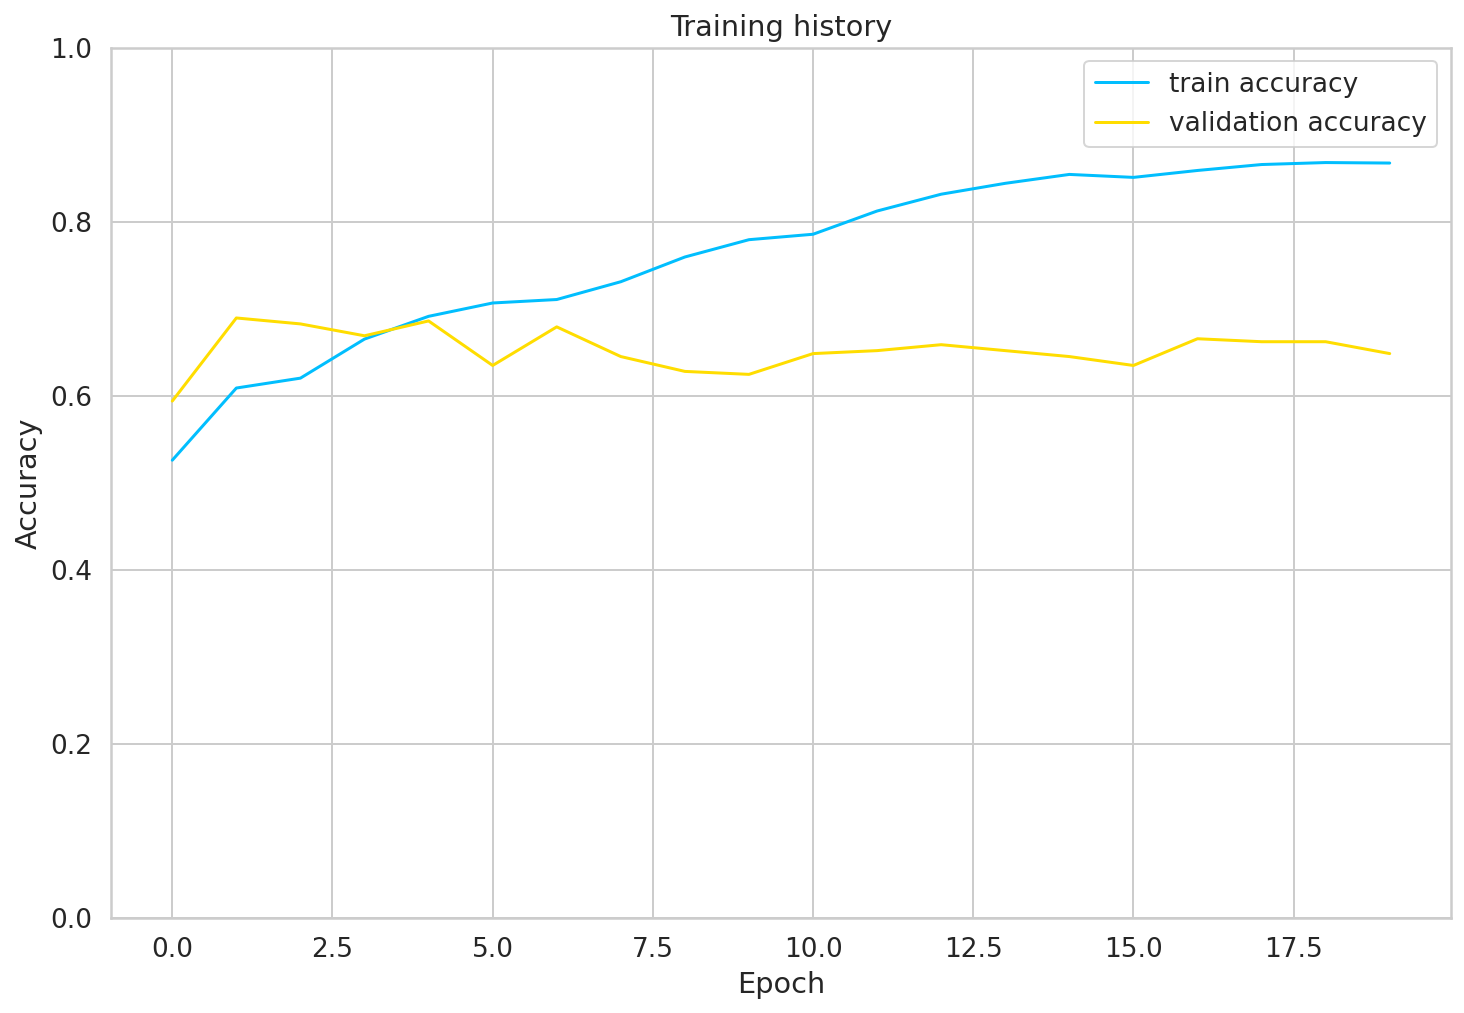

In [69]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [70]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.6530612244897959

In [71]:
def get_predictions(model, data_loader):
    model = model.eval()
    article_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["article_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            article_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return article_texts, predictions, prediction_probs, real_values

In [72]:
y_article_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [73]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.79      0.65      0.71       124
     Neutral       0.72      0.73      0.73       144
    Positive       0.13      0.23      0.17        26

    accuracy                           0.65       294
   macro avg       0.55      0.54      0.54       294
weighted avg       0.70      0.65      0.67       294



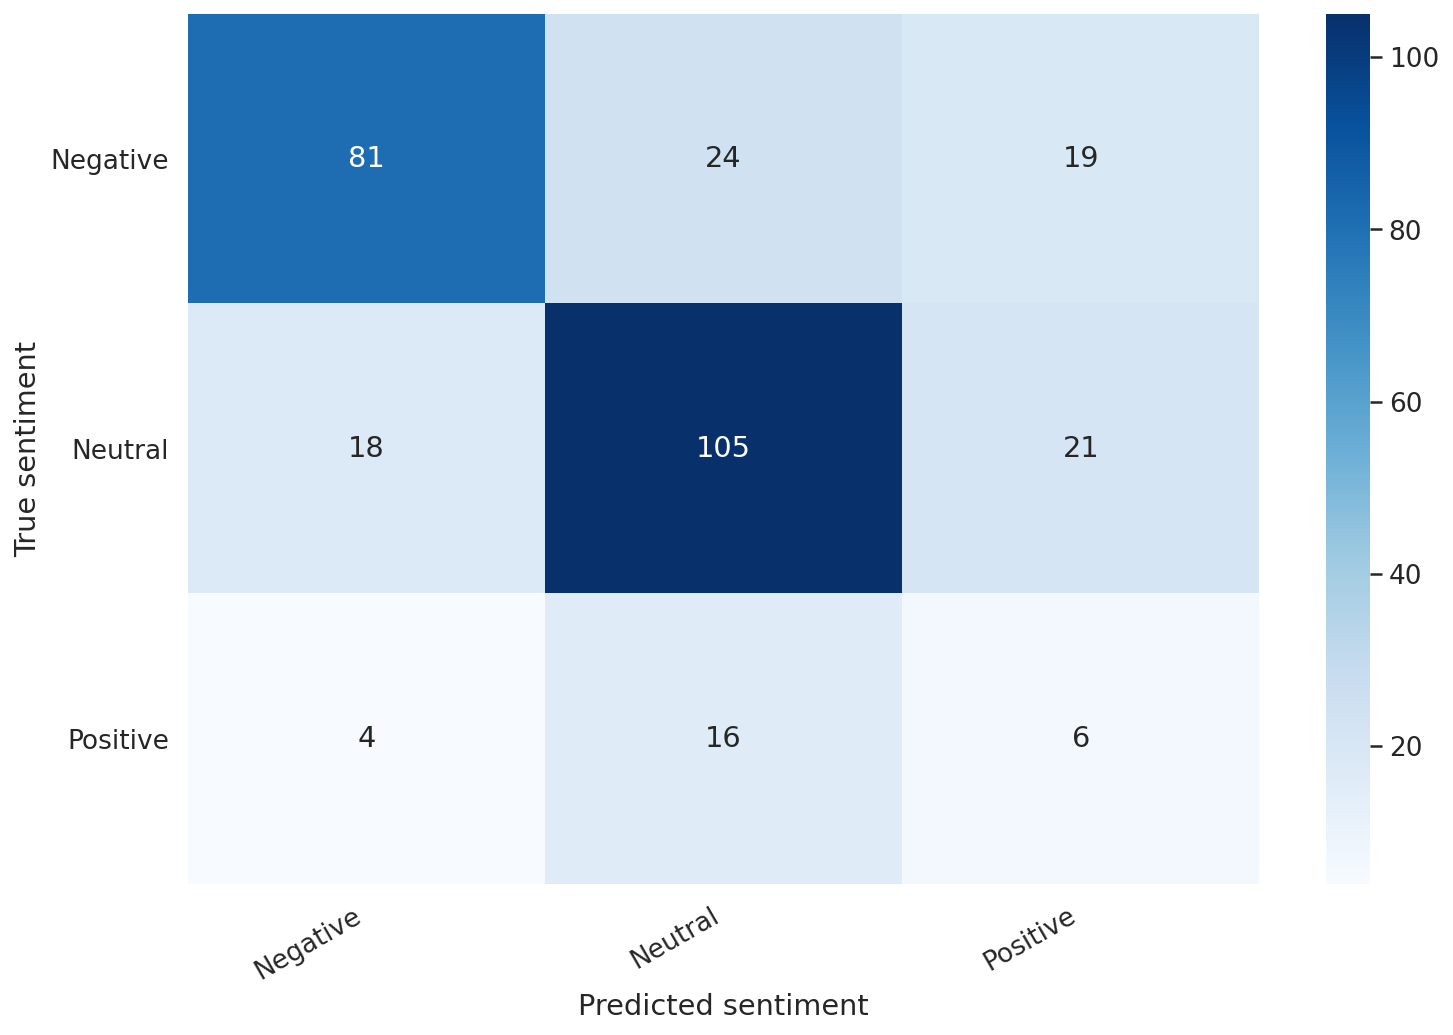

In [74]:
def show_confusion_matrix(confusion_matrix):
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Print example

In [75]:
idx = 2
article_text = y_article_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [76]:
print("\n".join(wrap(article_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

De cijferende belegger gaat een drukke tijd tegemoet. Halverwege
februari begint de stroom verslagen over het boekjaar 1990 op gang te
komen en zal blijken of de toch al niet juichende prognoses met de
werkelijkheid overeenkomen. Door de Golfoorlog wordt het
jaarverslagenseizoen met één dimensie 'verrijkt': de fluctuaties in de
noteringen voor ruwe olie. Koffiedikkijkers hadden verwacht dat die
noteringen bij het uitbreken van de oorlog gemakkelijk tot 80 a 100
dollar per barrel (159 liter) zouden kunnen stijgen. In werkelijkheid
zijn de noteringen echter met eenderde gedaald van rond 30 dollar tot
rond 20 dollar. De ene onderneming zal dolgelukkig zijn met goedkopere
olie, terwijl de andere daarvan een aanslag op de winst ver: wacht.

True sentiment: Positive


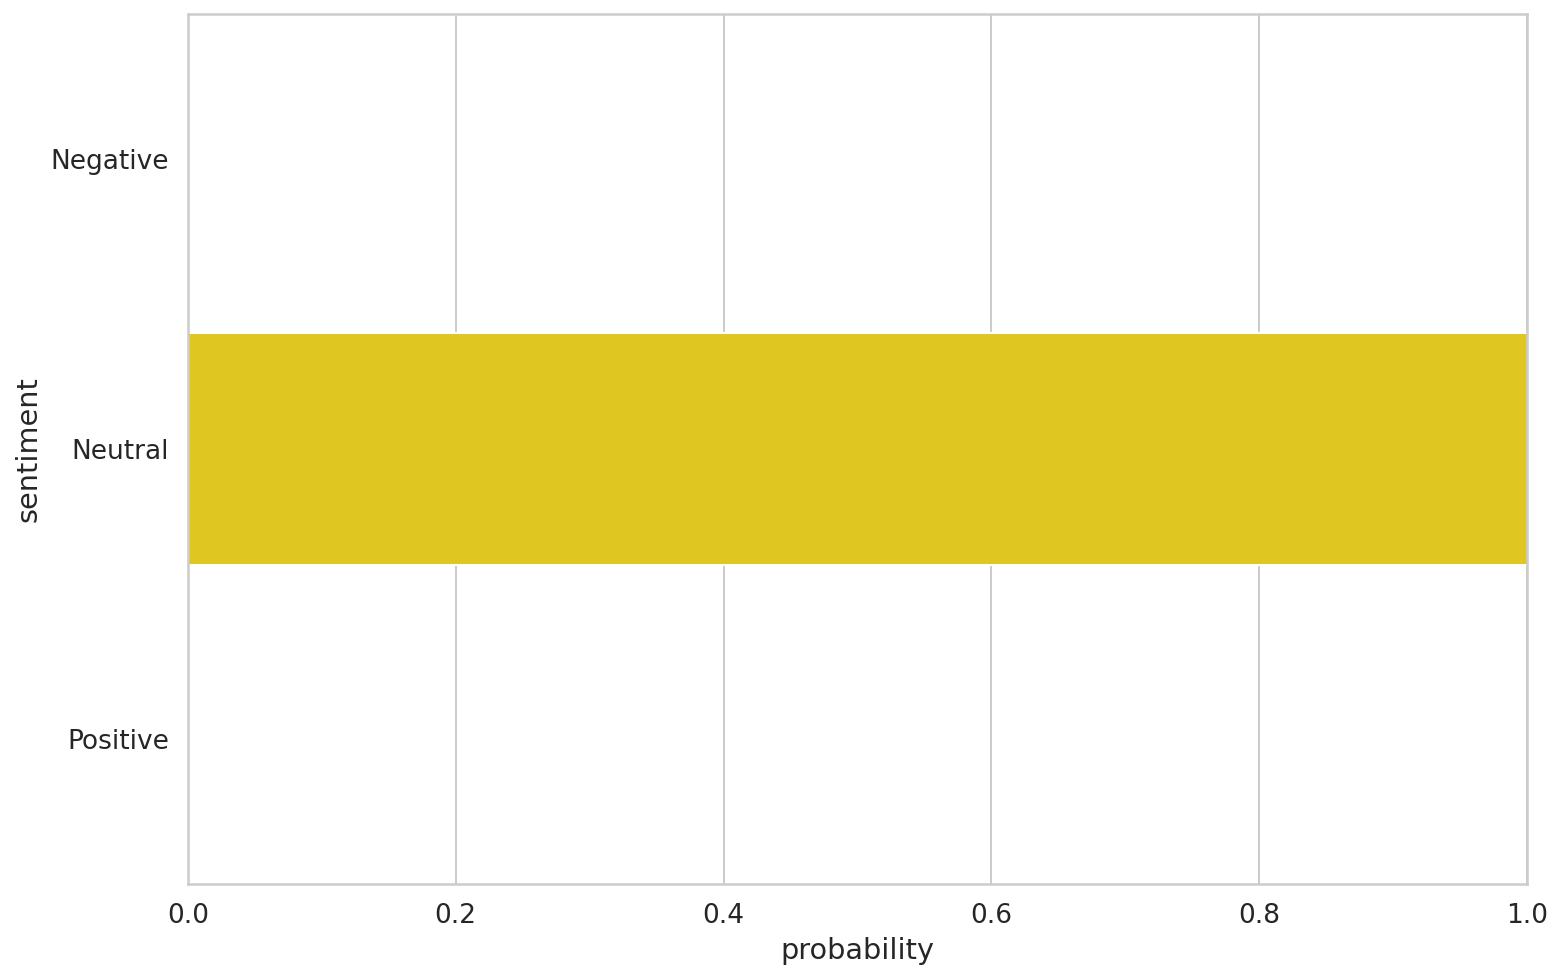

In [77]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting new articles

In [78]:
encoded_article = tokenizer.encode_plus(
    article_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

/home/leonardovida/.cache/pypoetry/virtualenvs/histaware-JJpORNNs-py3.8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1938: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [79]:
input_ids = encoded_article['input_ids'].to(device)
attention_mask = encoded_article['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {article_text}')
print(f'Predicted sentiment: {class_names[prediction]}')
print("-----------")

Review text: De cijferende belegger gaat een drukke tijd tegemoet. Halverwege februari begint de stroom verslagen over het boekjaar 1990 op gang te komen en zal blijken of de toch al niet juichende prognoses met de werkelijkheid overeenkomen. Door de Golfoorlog wordt het jaarverslagenseizoen met één dimensie 'verrijkt': de fluctuaties in de noteringen voor ruwe olie. Koffiedikkijkers hadden verwacht dat die noteringen bij het uitbreken van de oorlog gemakkelijk tot 80 a 100 dollar per barrel (159 liter) zouden kunnen stijgen. In werkelijkheid zijn de noteringen echter met eenderde gedaald van rond 30 dollar tot rond 20 dollar. De ene onderneming zal dolgelukkig zijn met goedkopere olie, terwijl de andere daarvan een aanslag op de winst ver: wacht.
Predicted sentiment: Neutral
-----------
